In [8]:
# Importing all the necessary libraries for this project.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import re
from nltk import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import string
import math

### importing all the models directory

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [9]:
import matplotlib.style as style
style.use('seaborn-poster')
style.use('fivethirtyeight')
plt.rcParams["font.family"] = "serif"

In [10]:
# VIEW ALL COLUMNS & ALL TEXT IN EACH CELL

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 20)

# Set ipython's max row display
pd.set_option('display.max_row', 200)


In [11]:
final_review = pd.read_csv('Final_Review.csv', index_col=0)
whisky_pd = pd.read_csv('Whisky_EDA.csv', index_col=0)

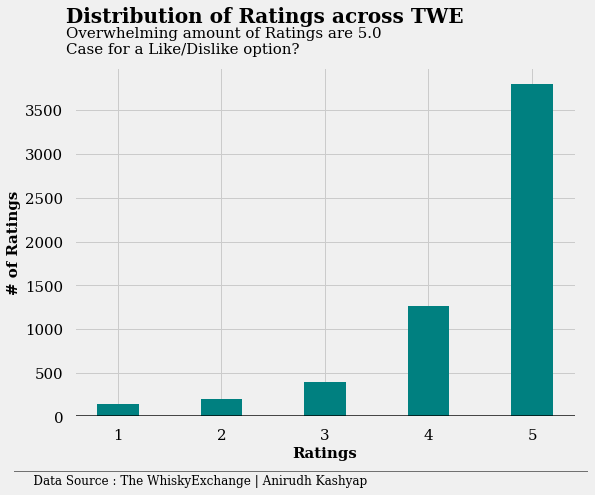

In [13]:
### PLOTTING REVIEW DISTRIBUTION

discusclass =list(final_review['Ratings'].value_counts().keys())
discusvalues = list(final_review['Ratings'].value_counts().values)

#PLOTTING THE CLASSIFICATION DISTRIBUTION

plt.figure(figsize=(8,6))
boxplot = plt.bar(discusclass, discusvalues, width = 0.4, align = 'center', color = 'teal')
plt.xlabel('Ratings', fontsize = 15, weight = 'bold')
plt.ylabel('# of Ratings', fontsize = 15, weight = 'bold')
plt.xticks(discusclass)
plt.axhline(y = 5, color = 'black', linewidth = 3, alpha = .7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(x=0.5, y=4500, s = 'Distribution of Ratings across TWE', fontsize = 20, weight = 'bold')
plt.text(x=0.5, y=4150, s = 'Overwhelming amount of Ratings are 5.0\nCase for a Like/Dislike option?', fontsize = 15)
plt.text(x=0, y=-775, s = '     Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = 0, y = -575,
    s = '__________________________________________________________________________________',
    color = 'black', alpha = .7)
plt.show()

In [14]:
def comcategorizer(ratings):
    if ratings < 5:
        return 0
    else:
        return 1

final_review['CommentsLevel'] = final_review['Ratings'].apply(comcategorizer)

In [33]:
def comment_cleaner(review):
    
    ## remove \n
    
    review = str(review).replace('\n', '').replace(',', ' ').replace('.', ' ').replace('"', '')
    
    review = review.lower()

    return review

final_review['Reviews'] = final_review['Reviews'].apply(comment_cleaner)

In [34]:
from nltk.corpus import stopwords
new_stop = stopwords.words('english')

otherwords = ['whisky', 'whiskey', 'bottle', 'bottled', 'glass']

new_stop = new_stop + otherwords

In [60]:
## GET A LIST OF FLAVORS HERE

flavorlist = list(whisky_pd['Character'])
flavorlist

completeflavors = []
for i in flavorlist:
    if type(i)==float:
        pass
    else:
        for j in i.split():
            j = j.lower().replace('(', '').replace(')', '')
            completeflavors.append(j)

## REMOVE 'CHARACTER'

otherflavors = ['peat', 'sherry', 'wine', 'rum', 'citrus', 'bourbon', 'cocoa', 'complex', 'creamy', 'oloroso', 'corn', 'fire', 'herbal', 'sea', 'maple', 'medicinal', 'moonshine', 'nectar', 'organic', 'roasted', 'chocolatey', 'peaty', 'smoky', 'nut', 'brine', 'briny', 'maritime', 'light', 'smooth', 'harsh', 'moss', 'rough', 'sherry', 'wine', 'rum']
completeflavors.extend(otherflavors)

## REMOVE DUPLICATES
completeflavors = list(set(completeflavors))
completeflavors.remove('old')

In [61]:
## START WITH COUNTVECTORIZER

countvec = CountVectorizer(stop_words=new_stop, ngram_range=(1,1))
wordfeatures = countvec.fit_transform(final_review["Reviews"])

descriptions = pd.DataFrame(wordfeatures.todense(),columns=countvec.get_feature_names())

In [62]:
## GET LIST OF COUNTVECTORIZED COLUMNS

cols = descriptions.columns

In [63]:
## LIST OF MOST FREQUENTLY USED WORDS

mostwords = descriptions.transpose().sum(axis = 1).sort_values(0, ascending = False)
mostwords = mostwords.reset_index()
mostwords.columns = ['Word', "Frequency"]

In [64]:
## THE MISSING FLAVORS FROM REVIEWS ARE LISTED BELOW. THESE DID NOT SHOW UP IN COUNT VECTORS. TAKING THEM OUT

missingflavors = ['peardrops', 'sultana', 'cranberry', 'parma', 'matchbox', 'seashell', 'rosemary', 'blackberry', 'herb', 'praline', 'caraway']
finalflavors = [x for x in completeflavors if x not in missingflavors]


## SELECTING ONLY THE FLAVORS AS PREDICTORS

X = descriptions[finalflavors]

y = final_review['CommentsLevel']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [66]:
#H/T Dale Wahl/Joe Klien for helping create confusion matrix.

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

def eval_sklearn_model(y_true, predictions, model=None, X=None):
    """This function takes the true values for y and the predictions made by the model and prints out the confusion matrix along with Accuracy, Precision, and, if model and X provided, Roc_Auc Scores."""
    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions))
    print('\n')

In [67]:
%%time
logit = LogisticRegression(random_state=42)

model = logit.fit(X_train, y_train)
predictions = model.predict(X_test)

eval_sklearn_model(y_test, predictions)

True Negative:  68 | False Positive:  446
False Negative:  50 | True Positive:  890 

Sensitivity (TP/ TP + FN):  0.946808510638
Specificity (TN/ TN + FP):  0.132295719844 

Accuracy:  0.658872077029
Precision:  0.666167664671


CPU times: user 25.9 ms, sys: 6.13 ms, total: 32.1 ms
Wall time: 28.8 ms


In [68]:
### MAKE THE MODELS HERE

modelpdbin = pd.DataFrame(model.coef_)
modelpdbin.columns = X_train.columns

modelpdbin = modelpdbin.transpose()
modelpdbin = modelpdbin.reset_index(drop = False)
modelpdbin.columns = ['Flavors', 'Coefficients']
modelpdbin['Odds'] = np.e**modelpdbin['Coefficients']

In [69]:
## See the count of flavors here

flavorscount = pd.DataFrame(X.sum(axis = 0)).reset_index(drop = False)
flavorscount.columns = ['Flavors', 'Count']

In [70]:
### Merge modelpdbin (which contains coefficients & flavorscount)

modelpdbin = pd.merge(modelpdbin, flavorscount, on = 'Flavors', how = 'left')


In [71]:
modelpdbin = modelpdbin.sort_values('Count', ascending=False).reset_index(drop = True)
plotmodel = modelpdbin.head(10)
plotmodel

,Flavors,Coefficients,Odds,Count
0,smooth,0.242353,1.274244,1153
1,malt,-0.150525,0.860256,560
2,smoke,0.070029,1.072539,368
3,bourbon,-0.084235,0.919216,330
4,peat,-0.187500,0.829029,314
5,sherry,-0.216783,0.805105,239
6,light,-0.765563,0.465072,237
7,vanilla,-0.165462,0.847502,236
8,complex,0.198456,1.219519,202
9,fruit,0.037300,1.038004,190


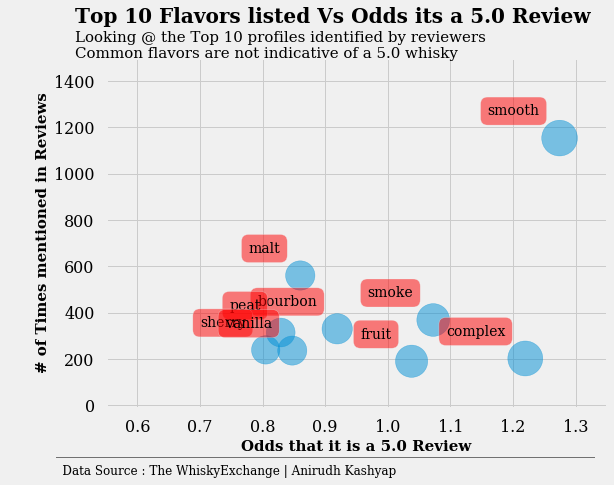

In [75]:
## Let us visualize this FOR TOP 10 FLAVORS

plt.figure(figsize=(8,6))
plt.scatter(plotmodel['Odds'], plotmodel['Count'], s = plotmodel['Odds']*1000, alpha=0.5)
labels = list(modelpdbin['Flavors'])
plt.xlim(0.55, 1.35)
plt.ylim(-10, 1500)
plt.xlabel('Odds that it is a 5.0 Review', fontsize = 15, weight = 'bold')
plt.ylabel('# of Times mentioned in Reviews', fontsize = 15, weight = 'bold')


for label, x, y in zip(labels, plotmodel['Odds'], plotmodel['Count']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round, pad=0.5', fc='red', alpha=0.5))
    
plt.text(x=0.5, y=1650, s = 'Top 10 Flavors listed Vs Odds its a 5.0 Review', fontsize = 20, weight = 'bold')
plt.text(x=0.5, y=1570, s = 'Looking @ the Top 10 profiles identified by reviewers', fontsize = 15)
plt.text(x=0.5, y=1500, s = 'Common flavors are not indicative of a 5.0 whisky', fontsize = 15)
plt.text(x=0.45, y=-300, s = '     Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = 0.47, y = -210,
    s = '_____________________________________________________________________________',
    color = 'black', alpha = .7)

plt.show()

In [76]:
modelpdbin = modelpdbin.sort_values('Odds', ascending=False).reset_index(drop = True)
plotmodel = modelpdbin.head(10)

In [82]:
plotmodel

,Flavors,Coefficients,Odds,Count
0,nectar,1.256018,3.511409,25
1,apricot,1.244286,3.470455,10
2,oil,1.116945,3.055506,15
3,wax,1.096973,2.995085,10
4,seaweed,0.769683,2.159082,6
5,briny,0.769021,2.157653,7
6,tea,0.730418,2.075949,19
7,stewed,0.584902,1.794816,4
8,aniseed,0.544190,1.723211,2
9,cinnamon,0.514053,1.672054,46


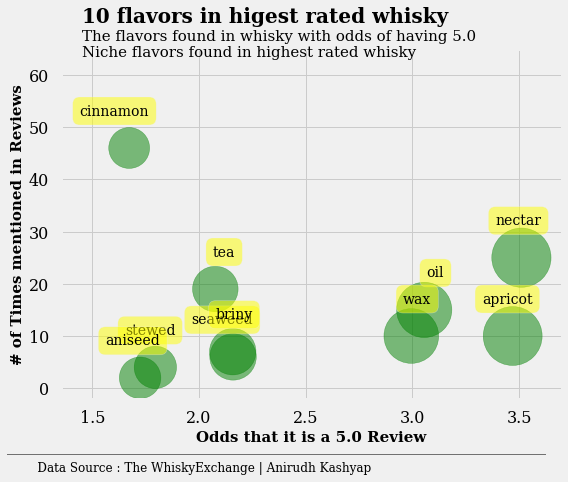

In [95]:
## Let us visualize this FOR TOP 10 FLAVORS

plt.figure(figsize=(8,6))
plt.scatter(plotmodel['Odds'], plotmodel['Count'], s = plotmodel['Odds']*1000, alpha=0.5, color = 'green')
labels = list(modelpdbin['Flavors'])
plt.xlim(1.35, 3.7)
plt.ylim(-2, 65)
plt.xlabel('Odds that it is a 5.0 Review', fontsize = 15, weight = 'bold')
plt.ylabel('# of Times mentioned in Reviews', fontsize = 15, weight = 'bold')


for label, x, y in zip(labels, plotmodel['Odds'], plotmodel['Count']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(20, 30),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round, pad=0.5', fc='yellow', alpha=0.5))
    
plt.text(x=1.45, y=70, s = '10 flavors in higest rated whisky', fontsize = 20, weight = 'bold')
plt.text(x=1.45, y=66.5, s = 'The flavors found in whisky with odds of having 5.0', fontsize = 15)
plt.text(x=1.45, y=63.5, s = 'Niche flavors found in highest rated whisky', fontsize = 15)
plt.text(x=1.15, y=-16, s = '     Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = 1.10, y = -12,
    s = '_____________________________________________________________________________',
    color = 'black', alpha = .7)

plt.show()

In [97]:
### TRYING JUST THE SIMPLE COUNTVEC NOW

X = descriptions.drop(finalflavors, axis = 1)

y = final_review['CommentsLevel']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

logit = LogisticRegression(penalty='l2', random_state=42)

model = logit.fit(X_train, y_train)
predictions = model.predict(X_test)

eval_sklearn_model(y_test, predictions)

True Negative:  270 | False Positive:  244
False Negative:  123 | True Positive:  817 

Sensitivity (TP/ TP + FN):  0.86914893617
Specificity (TN/ TN + FP):  0.525291828794 

Accuracy:  0.747592847318
Precision:  0.770028275212




In [111]:
### MAKE THE MODELS HERE

modelpdbin = pd.DataFrame(model.coef_)
modelpdbin.columns = X_train.columns

modelpdbin = modelpdbin.transpose()
modelpdbin = modelpdbin.reset_index(drop = False)
modelpdbin.columns = ['Factors', 'Coefficients']
modelpdbin['Odds'] = np.e**modelpdbin['Coefficients']

In [112]:
modelpdbin = modelpdbin.sort_values('Odds', ascending=False).reset_index(drop = True)
plotmodel = modelpdbin.head(12)
plotmodel

,Factors,Coefficients,Odds
0,outstanding,1.832125,6.247151
1,highly,1.229685,3.420151
2,fantastic,1.209626,3.352232
3,wonderfully,1.203199,3.330756
4,watered,1.184532,3.269155
5,fabulous,1.176727,3.243739
6,best,1.166416,3.210466
7,wow,1.162904,3.199210
8,favourite,1.154121,3.171234
9,already,1.153516,3.169316


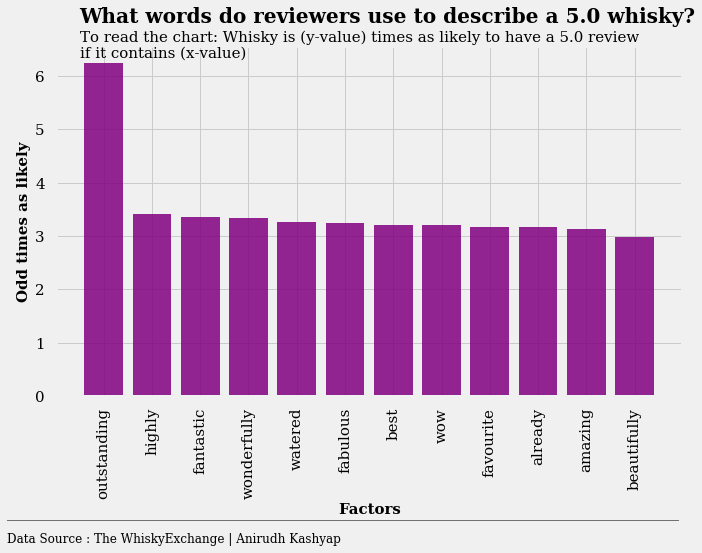

In [115]:
#PLOTTING THE CLASSIFICATION ODDS DISTRIBUTION CLASS 3

plt.figure(figsize=(10,6))

bars = tuple(plotmodel['Factors'].head(15))
y_pos = np.arange(len(bars))
odds_number = list(plotmodel['Odds'].head(15))


barplot = plt.bar(y_pos, odds_number, color = 'purple', alpha = 0.85)
plt.xlabel('Factors', fontsize = 15, weight = 'bold')
plt.ylabel('Odd times as likely', fontsize = 15, weight = 'bold')
plt.xticks(y_pos, bars, rotation=90)
plt.axhline(y = -0, color = 'black', linewidth = 3, alpha = .7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(x=-0.5, y=7.0, s = 'What words do reviewers use to describe a 5.0 whisky?', fontsize = 20, weight = 'bold')
plt.text(x=-0.5, y=6.35, s = 'To read the chart: Whisky is (y-value) times as likely to have a 5.0 review\nif it contains (x-value)', fontsize = 15)
plt.text(x=-2, y=-2.75, s = 'Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = -2, y = -2.25, s = '________________________________________________________________________________________________'
         ,color = 'black', alpha = .7)
plt.show()

In [116]:
modelpdbin = modelpdbin.sort_values('Odds', ascending=False).reset_index(drop = True)
plotmodel = modelpdbin.tail(12)
plotmodel

,Factors,Coefficients,Odds
8788,bad,-1.200213,0.301130
8789,rewarding,-1.238871,0.289711
8790,poor,-1.279692,0.278123
8791,introduction,-1.330417,0.264367
8792,options,-1.344496,0.260671
8793,hit,-1.374327,0.253010
8794,worst,-1.379058,0.251816
8795,india,-1.432885,0.238619
8796,thin,-1.456971,0.232941
8797,lacking,-1.596499,0.202605
